# Excercises 2

## Notebook #2: WA state hourly data

UW Geospatial Data Analysis  
CEE498/CEWA599  
David Shean  

In [1]:
import os
from glob import glob
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Part 2: Hourly data for WA state

## Load the WA temperature, precipitation and snow depth products
* Note: these are extracted for 12:00 UTC
* Really want daily averages for much of this, but I didn't have time to go back and requery ERA5
* Let's use what we have to play around

In [2]:
#fn = 'WA_era5-land-monthly_averaged_reanalysis_by_hour_of_day.grib'
#wa_t = xr.open_dataset(fn, engine='cfgrib')

In [3]:
fn_list = ['era5_data/era5_WA_1979-2021_6hr/era5_WA_1979-2021_6hr_2m_temperature.nc', \
           'era5_data/era5_WA_1979-2021_6hr/era5_WA_1979-2021_6hr_total_precipitation.nc', 
           'era5_data/era5_WA_1979-2021_6hr/era5_WA_1979-2021_6hr_snow_depth.nc']

#### Use open_mfdataset to merge when opening
* Could have used `open_dataset` on each nc, then combined
* http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html
* See more details on merge/combine in xarray: http://xarray.pydata.org/en/stable/combining.html

In [4]:
#Specify chunks to split
#chunks={'time':2048}
chunks=None

In [5]:
wa_merge = xr.open_mfdataset(fn_list, combine='by_coords', chunks=chunks)
wa_merge = wa_merge.sel(step=0)

In [6]:
wa_merge

<xarray.Dataset>
Dimensions:    (latitude: 13, longitude: 30, time: 61592)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 ... 2021-02-26T18:00:00
  * latitude   (latitude) float64 48.75 48.5 48.25 48.0 ... 46.25 46.0 45.75
  * longitude  (longitude) float64 -124.5 -124.2 -124.0 ... -117.8 -117.5 -117.2
Data variables:
    sd         (time, latitude, longitude) float32 dask.array<chunksize=(61592, 13, 30), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(61592, 13, 30), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(61592, 13, 30), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-03-04T16:33:29 GRIB to CDM+CF via cfgrib-0....

In [7]:
wa_merge['t2m'] -= 273.15
wa_merge['t2m'].attrs['units'] = 'C'

In [8]:
#Convert meters to mm
wa_merge['tp'] *= 1000
wa_merge['tp'].attrs['units'] = 'mm'

In [9]:
wa_merge['t2m']

<xarray.DataArray 't2m' (time: 61592, latitude: 13, longitude: 30)>
dask.array<sub, shape=(61592, 13, 30), dtype=float32, chunksize=(61592, 13, 30), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 ... 2021-02-26T18:00:00
  * latitude   (latitude) float64 48.75 48.5 48.25 48.0 ... 46.25 46.0 45.75
  * longitude  (longitude) float64 -124.5 -124.2 -124.0 ... -117.8 -117.5 -117.2
Attributes:
    GRIB_paramId:                             167
    GRIB_shortName:                           2t
    GRIB_units:                               K
    GRIB_name:                                2 metre temperature
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    GRIB_missingValue:                        9999
    GRIB_numberOfPoints:                      390
    GRIB_totalNumber:                         0
    GRIB_typeOfLevel:                         surface
    GRIB_NV:                                  0
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    GRIB_gridType:                            regular_ll
    GRIB_gridDefinitionDescription:           Latitude/Longitude Grid
    GRIB_Nx:                                  30
    GRIB_iDirectionIncrementInDegrees:        0.25
    GRIB_iScansNegatively:                    0
    GRIB_longitudeOfFirstGridPointInDegrees:  -124.5
    GRIB_longitudeOfLastGridPointInDegrees:   -117.25
    GRIB_Ny:                                  13
    GRIB_jDirectionIncrementInDegrees:        0.25
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   48.75
    GRIB_latitudeOfLastGridPointInDegrees:    45.75
    long_name:                                2 metre temperature
    units:                                    C
    coordinates:                              number time step surface latitu...

In [10]:
#wa_merge = wa_merge.dropna(dim='time')

In [11]:
#Unset units (avoid plotting in x and y label)
wa_merge['latitude'].attrs['units'] = None
wa_merge['longitude'].attrs['units'] = None

## Clip to WA state geometry

In [12]:
#wa_merge_clip = wa_merge.rio.write_crs(world.crs);
#wa_merge_clip = wa_merge_clip.rio.clip(wa_geom, crs=world.crs, drop=False)

## Compute seasonal mean values for each variable
* This is a simple `groupby()` and `mean()`
* Inspect the output values - do these make sense?

In [13]:
wa_merge_seasonal_mean = wa_merge.groupby('time.season').mean()

In [14]:
wa_merge_seasonal_mean

<xarray.Dataset>
Dimensions:    (latitude: 13, longitude: 30, season: 4)
Coordinates:
  * latitude   (latitude) float64 48.75 48.5 48.25 48.0 ... 46.25 46.0 45.75
  * longitude  (longitude) float64 -124.5 -124.2 -124.0 ... -117.8 -117.5 -117.2
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    sd         (season, latitude, longitude) float32 dask.array<chunksize=(1, 13, 30), meta=np.ndarray>
    t2m        (season, latitude, longitude) float32 dask.array<chunksize=(1, 13, 30), meta=np.ndarray>
    tp         (season, latitude, longitude) float32 dask.array<chunksize=(1, 13, 30), meta=np.ndarray>

In [15]:
#Hack to reorder seasons, as default is alphabetical
#order = np.array(['DJF', 'MAM', 'JJA', 'SON'], dtype=object)
order = np.array([0,2,1,3])
#wa_merge_seasonal_mean.season.values
wa_merge_seasonal_mean = wa_merge_seasonal_mean.isel(season=order)

In [16]:
#wa_merge_seasonal_resample = wa_merge.resample(time='Q-NOV').mean('time')

## Plot seasonal mean grids
* Note that plot will assume `x='longitude', y='latitude'`, but can also explicitly specify

In [17]:
wa_merge_seasonal_mean.data_vars

Data variables:
    sd       (season, latitude, longitude) float32 dask.array<chunksize=(1, 13, 30), meta=np.ndarray>
    t2m      (season, latitude, longitude) float32 dask.array<chunksize=(1, 13, 30), meta=np.ndarray>
    tp       (season, latitude, longitude) float32 dask.array<chunksize=(1, 13, 30), meta=np.ndarray>

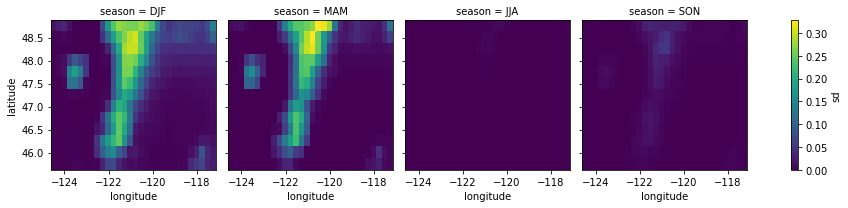

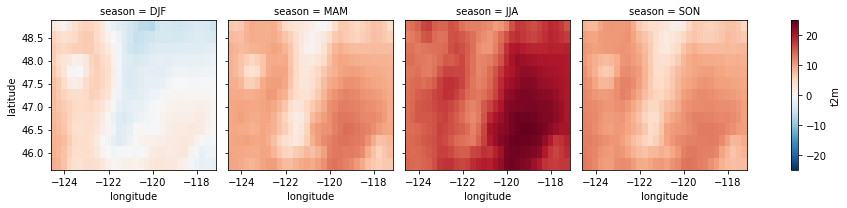

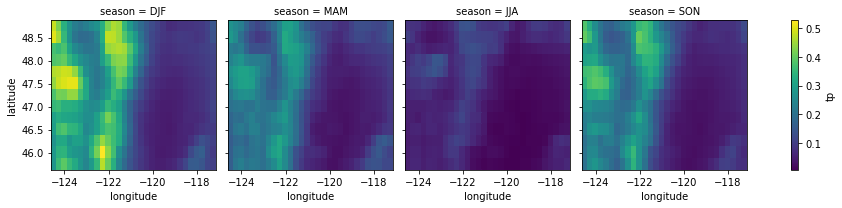

In [18]:
for i in wa_merge_seasonal_mean.data_vars:
    wa_merge_seasonal_mean[i].plot(col='season')

## Compute mean monthly values for WA state

In [19]:
wa_monthly_mean = wa_merge.groupby('time.month').mean('time').mean(['latitude','longitude'])
wa_monthly_mean

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sd       (month) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    t2m      (month) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    tp       (month) float32 dask.array<chunksize=(1,), meta=np.ndarray>

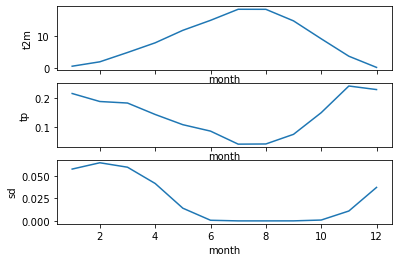

In [20]:
f, axa = plt.subplots(3,1, sharex=True)
wa_monthly_mean['t2m'].plot(ax=axa[0])
wa_monthly_mean['tp'].plot(ax=axa[1])
wa_monthly_mean['sd'].plot(ax=axa[2]);

## Helper function for plotting WA grids with state outline overlay

In [21]:
def plotwa(ds_in, v_list=['t2m','tp','sd'], op='mean'):
    f,axa = plt.subplots(1,3, figsize=(12,2), sharex=True, sharey=True)
    for i,v in enumerate(v_list):
        ds_in[v].plot(ax=axa[i], robust=True)
        wa_state.plot(ax=axa[i], facecolor='none', edgecolor='black')
        axa[i].set_title('WA State ERA5 Hourly: %s %s' % (op, v))
    f.tight_layout()

## Get the WA state outline

In [22]:
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)

In [23]:
wa_state = states_gdf.loc[states_gdf['NAME'] == 'Washington']

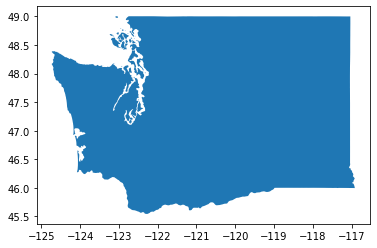

In [24]:
wa_state.plot();

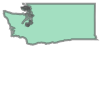

In [25]:
wa_geom = wa_state.iloc[0].geometry
wa_geom

## Create some plots of descriptive stats (mean, max, min, std) for 1979-present
* Pass the relevant dataset (e.g. `wa_merge.mean('time')`) to the `plotwa` helper function
* What do these metrics tell you?
    * What is causing most of the temperature variability captured by the std?
    * What is the highest temperature value

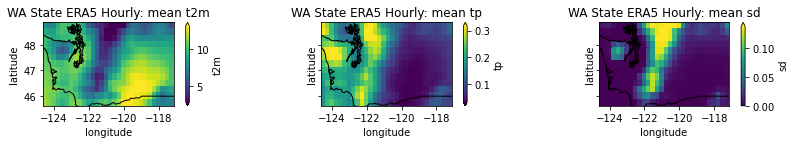

In [26]:
plotwa(wa_merge.mean('time'), op='mean')

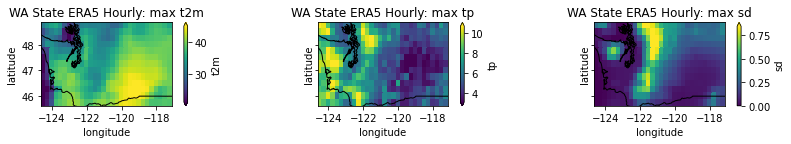

In [27]:
plotwa(wa_merge.max('time'), op='max')

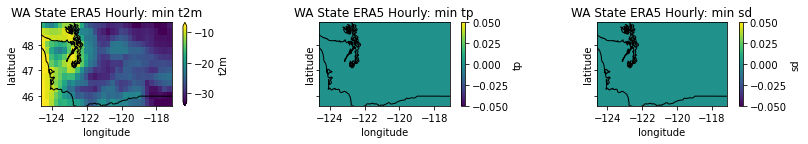

In [28]:
plotwa(wa_merge.min('time'), op='min')

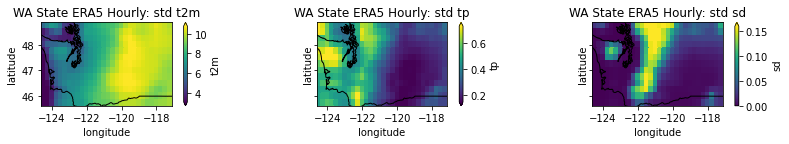

In [29]:
plotwa(wa_merge.std('time'), op='std')

## Create a plot showing the conditions the day before and after the Mt. St. Helen's eruption

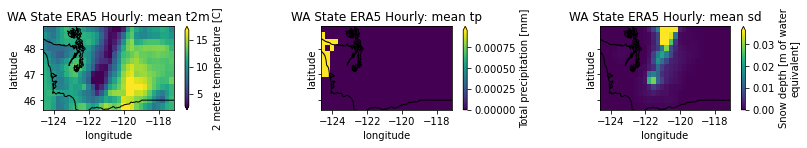

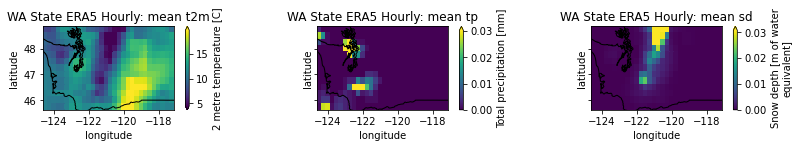

In [30]:
pre = wa_merge.sel(time='1980-05-18T06:00')
plotwa(pre)
post = wa_merge.sel(time='1980-05-19T06:00')
plotwa(post)

## Extract the time series for Seattle and Mt. Rainier temperature and create line plot
* You'll need to look up coordinates
    * Check the longitude system in the DataArrays (-180 to 180, or 0 to 360)
* Can use the `sel()` method to extract time series for the grid cell nearest the specified 'longitude' and 'latitude' coordinates
    * http://xarray.pydata.org/en/stable/indexing.html
    * Remember, these are large grid cells (~31x31 km), so one grid cell could cover the most of Mt. Rainier (a single temperature value that includes the cold summit and the warmer, lowland river valleys)
* Sanity check

In [31]:
sea_coord = (-122.25, 47.5)
rainier_coord = (121.7603, 46.8523)

In [32]:
sea_ts = wa_merge.sel(longitude=sea_coord[0], latitude=sea_coord[1], method='nearest')
sea_ts

<xarray.Dataset>
Dimensions:    (time: 61592)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 ... 2021-02-26T18:00:00
    latitude   float64 47.5
    longitude  float64 -122.2
Data variables:
    sd         (time) float32 dask.array<chunksize=(61592,), meta=np.ndarray>
    t2m        (time) float32 dask.array<chunksize=(61592,), meta=np.ndarray>
    tp         (time) float32 dask.array<chunksize=(61592,), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-03-04T16:33:29 GRIB to CDM+CF via cfgrib-0....

In [33]:
rainier_ts = wa_merge.sel(longitude=rainier_coord[0], latitude=rainier_coord[1], method='nearest')
rainier_ts

<xarray.Dataset>
Dimensions:    (time: 61592)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 ... 2021-02-26T18:00:00
    latitude   float64 46.75
    longitude  float64 -117.2
Data variables:
    sd         (time) float32 dask.array<chunksize=(61592,), meta=np.ndarray>
    t2m        (time) float32 dask.array<chunksize=(61592,), meta=np.ndarray>
    tp         (time) float32 dask.array<chunksize=(61592,), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-03-04T16:33:29 GRIB to CDM+CF via cfgrib-0....

In [34]:
rainier_ts.time.values.min()

numpy.datetime64('1979-01-01T00:00:00.000000000')

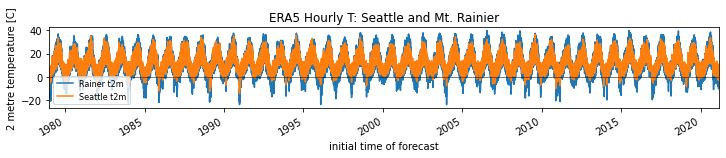

In [35]:
f, ax = plt.subplots(figsize=(12,1.5))
v = 't2m'
rainier_ts[v].plot(ax=ax, label='Rainer %s' % v)
sea_ts[v].plot(ax=ax, label='Seattle %s' % v)
ax.axhline(0,color='k',lw=0.5)
ax.legend(fontsize=8)
ax.set_xlim(rainier_ts.time.values.min(), rainier_ts.time.values.max())
ax.set_title("ERA5 Hourly T: Seattle and Mt. Rainier");

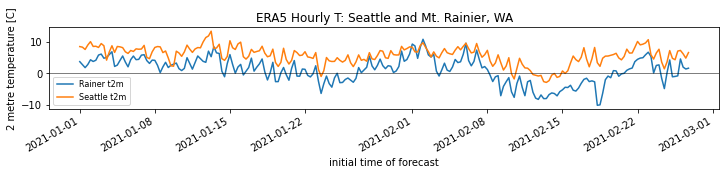

In [36]:
f, ax = plt.subplots(figsize=(12,1.5))
v = 't2m'
cy = 2021
rainier_ts[v].loc[f'{cy}-01-01':].plot(ax=ax, label='Rainer %s' % v)
sea_ts[v].loc[f'{cy}-01-01':].plot(ax=ax, label='Seattle %s' % v)
ax.axhline(0,color='k',lw=0.5)
ax.legend(fontsize=8)
ax.set_title("ERA5 Hourly T: Seattle and Mt. Rainier, WA");

## Helper function to plot time series

In [37]:
def plotv(ds_in, v_list=['t2m','tp','sd']):
    f,axa = plt.subplots(3,1, figsize=(10,6), sharex=True)
    for i,v in enumerate(v_list):
        ds_in[v].dropna(dim='time').plot(ax=axa[i], lw=0.5)
        axa[i].axhline(0,color='k',lw=0.5)
    f.tight_layout()

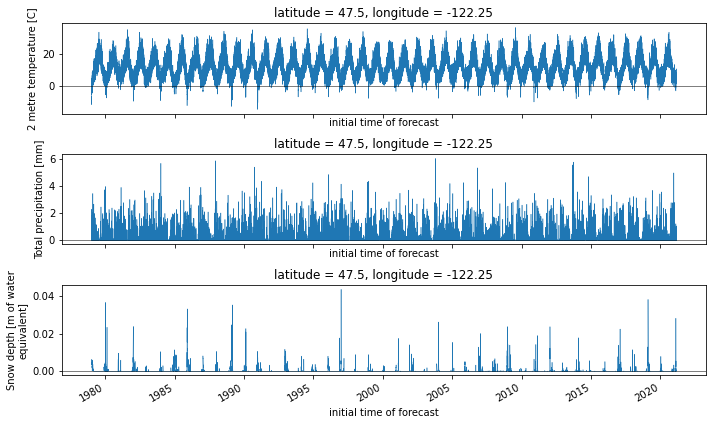

In [38]:
plotv(wa_merge.sel(longitude=sea_coord[0], latitude=sea_coord[1], method='nearest'))

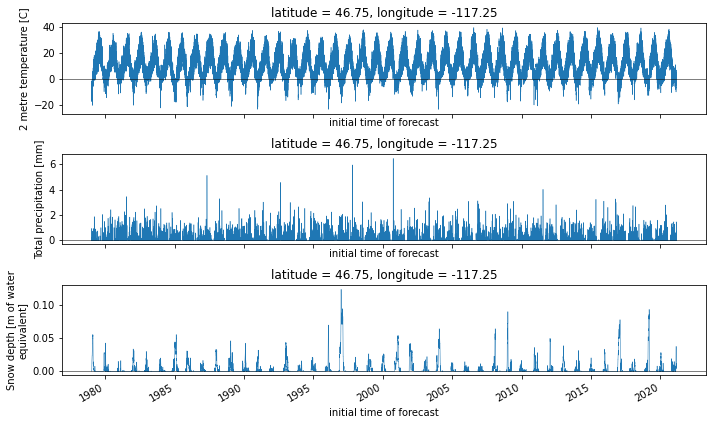

In [39]:
plotv(wa_merge.sel(longitude=rainier_coord[0], latitude=rainier_coord[1], method='nearest'))

## Compute stats for monthly, annual time periods
* Can use `groupby('time.year').max(dim='time')`
* Plot snow depth for April and September

## Create a map that shows the year containing the maximum T value at each grid cell
* These should mostly be in the most recent decade
* Note the `.compute()` is needed to converty dask array to ndarray for use in vectorized indexing

In [40]:
max_t_idx = wa_merge['t2m'].argmax(dim='time').compute()

In [41]:
wa_merge['t2m']['time.year']

<xarray.DataArray 'year' (time: 61592)>
array([1979, 1979, 1979, ..., 2021, 2021, 2021])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2021-02-26T18:00:00

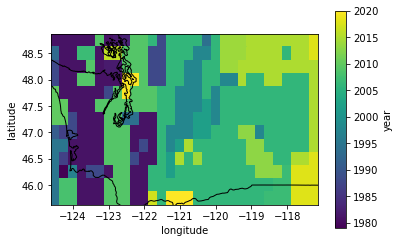

In [42]:
f, ax = plt.subplots()
wa_merge['t2m']['time.year'][max_t_idx].plot(ax=ax)
wa_state.plot(ax=ax, facecolor='none', edgecolor='black');

In [43]:
wa_merge['t2m']['time.year'][max_t_idx].median()

<xarray.DataArray 'year' ()>
array(2006.)

# Extra Credit

## Create a new xarray Dataset with the SNOTEL data from Lab08

## Export one of the derived WA grids to rasterio
* https://github.com/robintw/XArrayAndRasterio/blob/master/rasterio_to_xarray.py

## Load SRTM DEM for WA
* Resample

## Plot contours from SRTM DEM over temperature grid

## Compute correlation between temperature and elevation
* https://github.com/pydata/xarray/issues/1115

## Compute atmospheric temperature lapse rate using SRTM elevations

# What if my data are too big?
* http://xarray.pydata.org/en/stable/dask.html